# Comparing simulation output for variance estimation

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

In [105]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [106]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')
import memento
import memento.auxillary.simulate as simulate

In [107]:
data_path = '/home/ubuntu/Data/'


In [108]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
%autoreload 2

In [110]:
DATA_PATH = '/home/ubuntu/Data/'
MIN_MEAN_THRESH = 0.005

### Calculate concordances

In [227]:
def concordance(x, y, mask, log=True):
    
    cond = mask

    if log:
        a = np.log(x[cond])
        b = np.log(y[cond])
    else:
        a = x[cond]
        b = y[cond]
    # return cond.sum(), stats.pearsonr(a, b)[0]
    cmat = np.cov(a, b)
    return cond.sum(), 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [189]:
# Read smfish estimates
smfish_estimates = np.load(data_path + 'smfish/smfish_estimates.npz')
smfish_genes = list(smfish_estimates['var_genes'])
print('number of fish genes' ,len(smfish_genes))
smfish_variances = smfish_estimates['variance']

# Mean one includes GAPDH so remove that
smfish_means = np.array([m for g,m in zip(smfish_estimates['mean_genes'], smfish_estimates['mean']) if g != 'GAPDH'])

smfish_means = np.array([m for g,m in zip(smfish_estimates['mean_genes'], smfish_estimates['mean']) if g != 'GAPDH'])
smfish_cv = smfish_variances/smfish_means**2

number of fish genes 14


In [190]:
dropseq_genes = sc.read_h5ad(data_path + 'smfish/filtered_dropseq.h5ad').var.index.tolist()
smfish_gene_idxs = [dropseq_genes.index(smg) for smg in smfish_genes]
gapdh_idx = dropseq_genes.index('GAPDH')

In [197]:
variances = np.load(data_path + 'smfish/variance/sample_variances.npz')['variances']
means = np.load(data_path +'smfish/variance/sample_means.npz')['means']
cv = variances/means**2
meta = pd.read_csv(data_path + 'smfish/variance/sample_metadata.csv')

# OPTIONAL - filter genes for comparison
variances = variances[:, smfish_gene_idxs]
means = means[:, smfish_gene_idxs]
cv = cv[:, smfish_gene_idxs]

gene_names = [f'gene_{i}' for i in range(variances.shape[1])]

results = pd.concat([
    meta, 
    pd.DataFrame(cv, columns=gene_names)],
    axis=1)

/tmp/ipykernel_21189/3276985023.py:3: RuntimeWarning: invalid value encountered in divide
  cv = variances/means**2


In [198]:
# pd.DataFrame(zip(
#     smfish_estimates['mean_genes'], 
#     smfish_estimates['mean'],
#     smfish_estimates['variance'],
#     means[-3],
#     variances[-3],
#     means[-2],
#     variances[-2]),
#     columns=['gene', 'fish_m', 'fish_v', 'naive_m', 'naive_v', 'hyper_m', 'hyper_v']).sort_values('gene')

In [245]:
concordances = []
for name, group in results.groupby(['num_cell', 'trial']):
    methods = group['method']
    num_cell, trial = name
    indices = np.all((group[gene_names].values > 0), axis=0)
    for idx, method in enumerate(methods):
    
        estimates = group[gene_names].values[idx]
        
        num_genes_used, c = concordance(estimates, smfish_cv, indices)

        concordances.append((
            num_cell, 
            trial,
            method,
            num_genes_used,
            c
        ))
    
concordances = pd.DataFrame(concordances, columns=['num_cell', 'trial', 'method','num_valid_genes',  'concordance'])
concordances = concordances.query('num_valid_genes > 5')
concordances = concordances.query('~(num_cell == 1000 & method == "basics")')

In [247]:
def plot_curve(x, y, data, ax, marker, color, markersize, linestyle='-', label=''):
    
    agg_data = data.groupby(x)[y].agg(['mean', 'std'])
    x_data = agg_data.index
    y_data = agg_data['mean'].values
    y_err = agg_data['std']/np.sqrt(data.trial.max())
    
    ax.plot(np.arange(x_data.shape[0]), y_data, marker=marker, color=color, markersize=markersize, linestyle=linestyle, label=label)
    ax.fill_between(np.arange(x_data.shape[0]), y_data-y_err, y_data+y_err, alpha=0.2, color=color)
    ax.set_xticks(np.arange(x_data.shape[0]), x_data.astype(int))

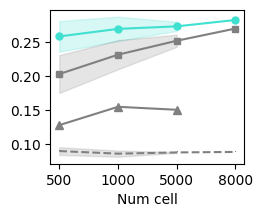

In [249]:
fig, ax = plt.subplots(figsize=(2.5,2))

plot_curve('num_cell', 'concordance', 
           data=concordances.query('method == "hypergeometric"'),
           ax=ax, 
           color='turquoise',
           marker='o', 
           markersize=5,
           label='memento')

plot_curve('num_cell', 'concordance', 
           data=concordances.query('method == "poisson"'),
           ax=ax, 
           color='gray', 
           marker="s", 
           markersize=5,
           label='Poisson')

plot_curve('num_cell', 'concordance', 
           data=concordances.query('method == "basics"'),
           ax=ax, 
           color='gray', 
           marker='^', 
           markersize=6,
           label='BASiCS')

plot_curve('num_cell', 'concordance', 
           data=concordances.query('method == "naive"'),
           ax=ax, 
           color='gray', 
           marker=",", 
           linestyle='--',
           markersize=5,
           label='naive')

plt.xlabel('Num cell')
# plt.ylabel('Concordance')
# plt.legend(frameon=False)
plt.savefig('variance_fish.pdf', bbox_inches='tight')